# 数値予報データ

気象庁の数値予報データを描いてみましょう。[気象庁メソモデル](https://www.jma.go.jp/jma/kishou/know/whitep/1-3-6.html)のデータを使います。まず，京都大学生存圏研究所から提供されている，解析値を中心に再構成し，扱いやすいNetCDF形式に変換したデータで3時間毎の解析値を描きます。ここでは例として2022年1月6日のデータを使います。`curl`でデータをダウンロードして，NetCDFファイルをxarrayで読みます。

In [1]:
import numpy as np
import xarray as xr

In [125]:
!curl -O http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/netcdf/MSM-P/2022/0106.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178M  100  178M    0     0  77.0M      0  0:00:02  0:00:02 --:--:-- 77.0M


In [126]:
ds = xr.open_dataset("0106.nc")

変数名などを確認するために，メタデータを表示します。

In [127]:
ds

<xarray.Dataset>
Dimensions:  (lat: 253, lon: 241, p: 16, time: 8)
Coordinates:
  * lon      (lon) float32 120.0 120.1 120.2 120.4 ... 149.6 149.8 149.9 150.0
  * lat      (lat) float32 47.6 47.5 47.4 47.3 47.2 ... 22.8 22.7 22.6 22.5 22.4
  * p        (p) float32 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
  * time     (time) datetime64[ns] 2022-01-06 ... 2022-01-06T21:00:00
Data variables:
    z        (time, p, lat, lon) float64 ...
    w        (time, p, lat, lon) float64 ...
    u        (time, p, lat, lon) float32 ...
    v        (time, p, lat, lon) float32 ...
    temp     (time, p, lat, lon) float32 ...
    rh       (time, p, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      created by create_1daync_msm_p.rb  2022-01-08

3時間毎に8時刻分のデータが格納されていることが分かります。1日分を1行に4時刻ずつ並べて描くことにします。850 hPa面で気温をカラーの陰影で，風をベクトルで描きます。

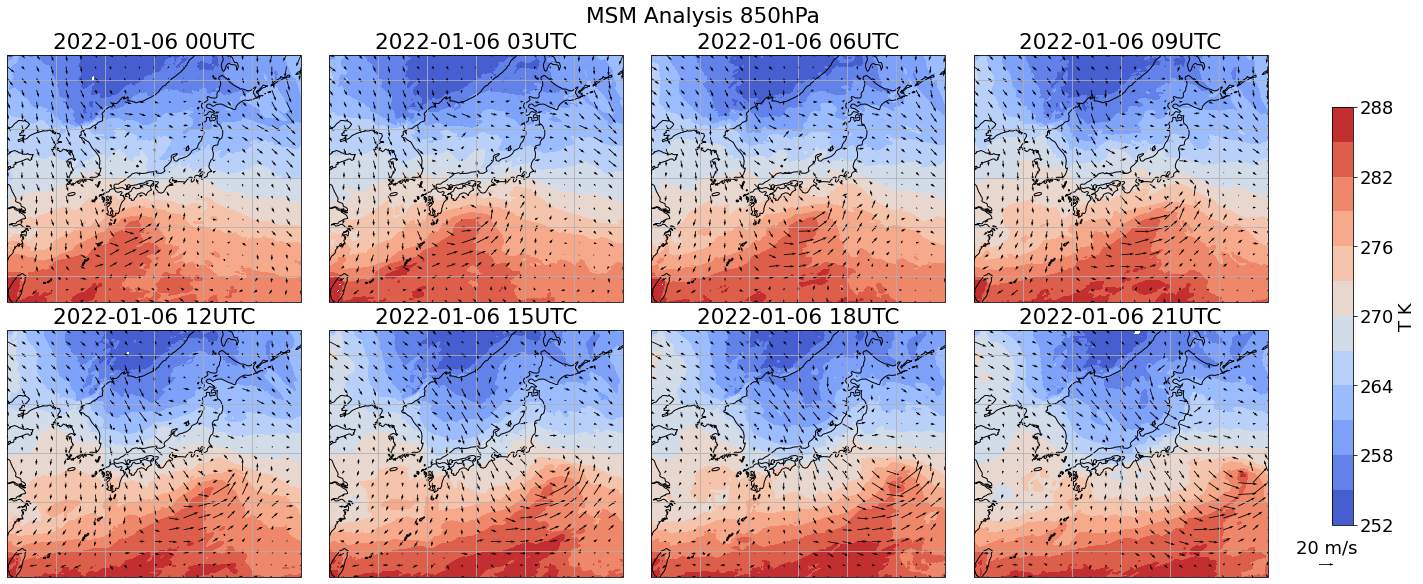

In [161]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=[20, 8], constrained_layout=True)

skip = 12
plev = 850
qx, qy, qk = 1.2, 0.05, 20
axs = []
tlevs = np.arange(252, 289, 3)
for i in range(ds.time.size):
    ax = fig.add_subplot(2, 4, i+1, projection=ccrs.PlateCarree())
    T = ds.temp.sel(p=plev).isel(time=i)
    u = ds.u.sel(p=plev).isel(time=i)[::skip, ::skip]
    v = ds.v.sel(p=plev).isel(time=i)[::skip, ::skip]
    p = ax.contourf(ds.lon, ds.lat, T,
                    tlevs, transform=ccrs.PlateCarree(), cmap="coolwarm")
    q = ax.quiver(ds.lon[::skip], ds.lat[::skip], u, v, scale=400, transform=ccrs.PlateCarree())
    if i+1==ds.time.size:
        ax.quiverkey(q, qx, qy, qk, f"{qk} m/s")
    ax.set_title(ds.time[i].dt.strftime("%Y-%m-%d %HUTC").values)
    ax.coastlines()
    ax.gridlines()
    axs.append(ax)
fig.colorbar(p, ax=axs, shrink=0.8, label="T K")
fig.suptitle(f"MSM Analysis {plev}hPa")
plt.show()

- 5行目: フォントサイズを一括して18ポイントにします。 
- 6行目: プロットの間の間隔を詰めるために`constrained_layout=True`としています。
- 8行目: ベクトルは22行目で`quiver()`を使って描きますが，そのままだとデータが多すぎるので12点毎にひとつ描くようにします。
- 11行目: `colorbar()`で使う`ax`を格納する空のリストを作ります。
- 12行目: 気温は3K毎に色を変えます。
- 15〜17行目: データセットから気温と風を変数に格納します。`sel()`で等圧面を気圧の値で，`isel()`で時刻を番号で選択します。
- 16, 17行目: `skip`を使って風を水平方向に間引いています。
- 18〜19行目: 気温を陰影で描きます。`colorbar()`に使うために，結果を`p`に格納します。
- 20行目: 風をベクトルで描きます。`quiverkey()`に使うために，結果を`q`に格納します。
- 23行目: タイトルとして時刻を設定します。
- 26行目: `ax`をリスト`axs`に追加します。
- 27行目: カラーバーを描きます。
- 28行目: 全体のタイトルとしてモデル名と気圧面を設定します。

南岸低気圧が東進して寒気が日本に吹き出しています。予報データと比較してみましょう。最新の予報データは`MSM-P.nc`などにリンクされています。また，最近1週間のデータが提供されています。執筆時点取得できた2022年1月6日00 UTCからの予報データを用います。

In [111]:
!curl -O http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/latest/MSM-P.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178M  100  178M    0     0  84.1M      0  0:00:02  0:00:02 --:--:-- 84.1M


In [129]:
!curl -O http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/latest/20220106/MSM2022010600P.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178M  100  178M    0     0  75.9M      0  0:00:02  0:00:02 --:--:-- 75.9M


In [130]:
ds1 = xr.open_dataset("MSM2022010600P.nc")

In [131]:
ds1

<xarray.Dataset>
Dimensions:  (lat: 253, lon: 241, p: 16, time: 12)
Coordinates:
  * lon      (lon) float32 120.0 120.1 120.2 120.4 ... 149.6 149.8 149.9 150.0
  * lat      (lat) float32 47.6 47.5 47.4 47.3 47.2 ... 22.8 22.7 22.6 22.5 22.4
  * p        (p) float32 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
  * time     (time) datetime64[ns] 2022-01-06 ... 2022-01-07T09:00:00
Data variables:
    z        (time, p, lat, lon) float32 ...
    w        (time, p, lat, lon) float32 ...
    u        (time, p, lat, lon) float32 ...
    v        (time, p, lat, lon) float32 ...
    temp     (time, p, lat, lon) float32 ...
    rh       (time, p, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      created by trans_latest_msm_p.rb  2022-01-06

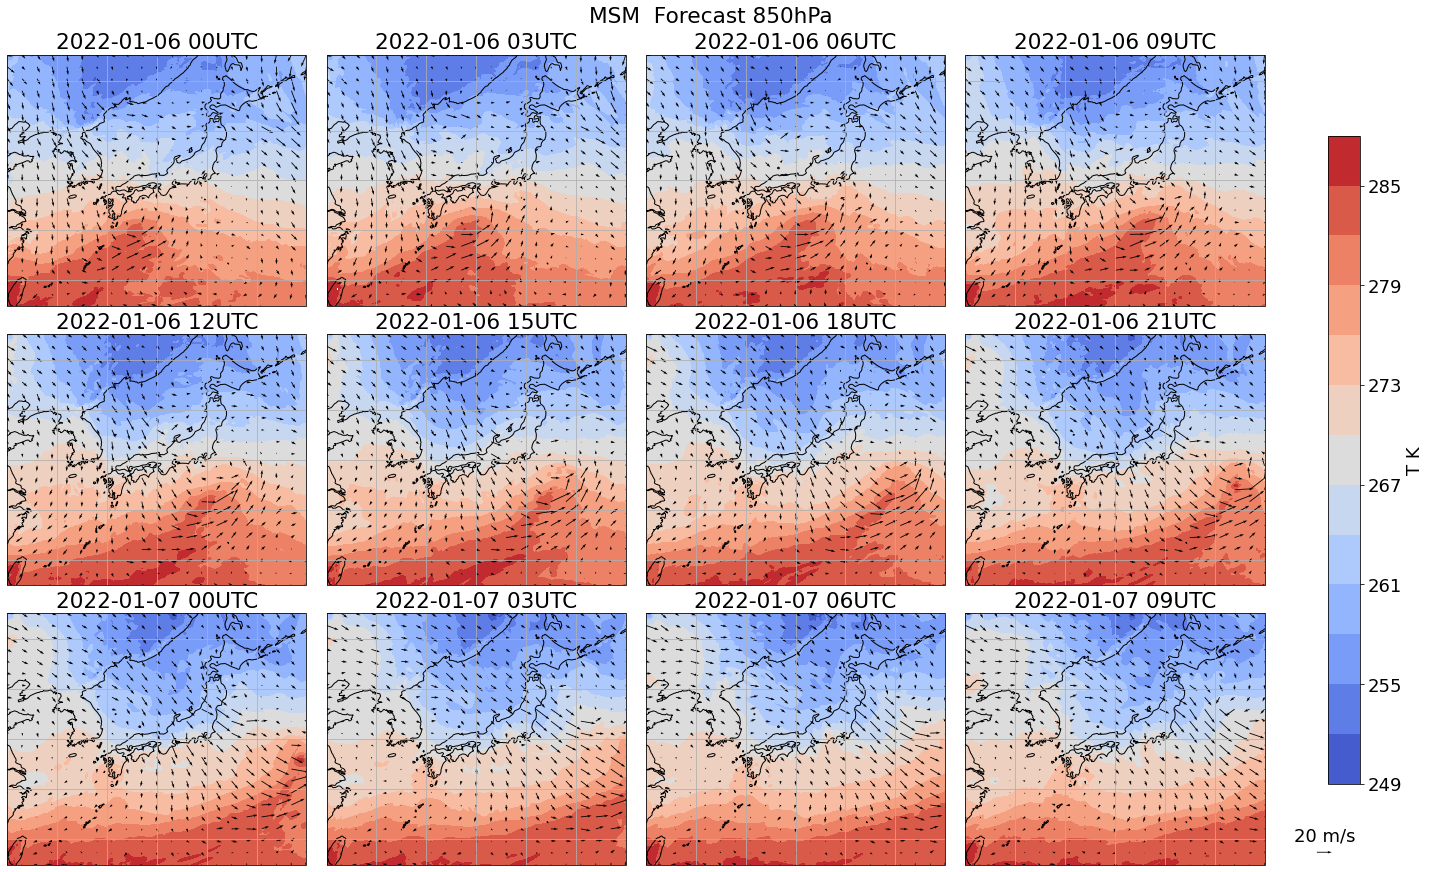

In [155]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=[20, 12], constrained_layout=True)

skip = 12
plev = 850
qx, qy, qk = 1.2, 0.05, 20
axs = []
tmax = ds1.temp.sel(p=plev).max()
tlevs = np.arange(252, 289, 3)
for i in range(ds1.time.size):
    T = ds1.temp.sel(p=plev).isel(time=i)
    u = ds1.u.sel(p=plev).isel(time=i)[::skip, ::skip]
    v = ds1.v.sel(p=plev).isel(time=i)[::skip, ::skip]
    p = ax.contourf(ds.lon, ds.lat, T,
                    tlevs, transform=ccrs.PlateCarree(), cmap="coolwarm")
    q = ax.quiver(ds.lon[::skip], ds.lat[::skip], u, v, scale=400, transform=ccrs.PlateCarree())
    if i+1==ds1.time.size:
        ax.quiverkey(q, qx, qy, qk, f"{qk} m/s")
    ax.set_title(ds1.time[i].dt.strftime("%Y-%m-%d %HUTC").values)
    ax.coastlines()
    ax.gridlines()
    axs.append(ax)
fig.colorbar(p, ax=axs, shrink=0.8, label="T K")
fig.suptitle(f"MSM  Forecast {plev}hPa")
plt.show()

- 6行目: 3行になるので図の高さを大きくします。
- 28行目: 全体のタイトルのAnalysisをForecastにしました。

予報ではやや寒気の吹き出しが弱い傾向がありますが，南岸低気圧とその後の冬型の強化が精度良く予報されています。

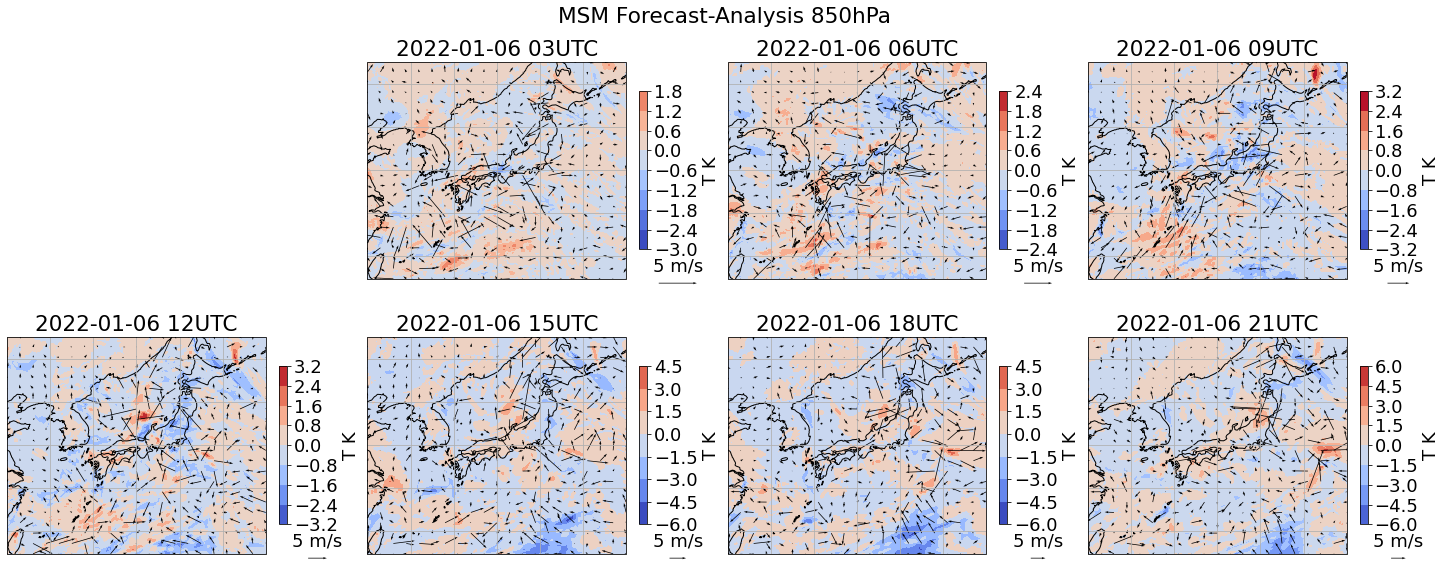

In [158]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=[20, 8], constrained_layout=True)

skip = 12
plev = 850
qx, qy, qk = 1.2, -0.02, 5
for i in range(1, ds.time.size):
    ax = fig.add_subplot(2, 4, i+1, projection=ccrs.PlateCarree())
    T = ds.temp.sel(p=plev).isel(time=i)
    dT = ds1.temp.sel(p=plev).isel(time=i) - T
    u = ds.u.sel(p=plev).isel(time=i)[::skip, ::skip]
    v = ds.v.sel(p=plev).isel(time=i)[::skip, ::skip]
    du = ds1.u.sel(p=plev).isel(time=i)[::skip, ::skip] - u
    dv = ds1.v.sel(p=plev).isel(time=i)[::skip, ::skip] - v
    p = ax.contourf(ds.lon, ds.lat, dT, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=dT.min(), vmax=-dT.min())
    q = ax.quiver(ds.lon[::skip], ds.lat[::skip], du, dv, transform=ccrs.PlateCarree())
    ax.quiverkey(q, qx, qy, qk, f"{qk} m/s")
    ax.set_title(ds.time[i].dt.strftime("%Y-%m-%d %HUTC").values)
    ax.coastlines()
    ax.gridlines()
    fig.colorbar(p, ax=ax, shrink=0.6, label="T K")
    fig.suptitle(f"MSM Forecast-Analysis {plev}hPa")
plt.show()